Various reaching tasks with planar manipulator modeled in single notebook

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np 

from planar_manipulator import PlanarManipulator
from plot_utils import plot_chain

np.set_printoptions(3, suppress=True)
torch.set_printoptions(3, sci_mode=False)

import sys
sys.path.append('../')
from ttgo import TTGO
import tt_utils
from utils import test_ttgo


from cost_utils import PlanarManipulatorCost
from utils import Point2PointMotion

import warnings
warnings.filterwarnings('ignore')


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ro8x7m78 because the default path (/idiap/home/sshetty/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
file_name = None # trained model

In [17]:
# Define the robot
n_joints = 3
link_lengths = torch.tensor([1./n_joints]*n_joints).to(device)
max_theta = torch.pi
min_theta = -1*max_theta
n_kp = 10;
dt = 0.01;
d0_x = 10; d0_theta = 10; d0_w = 10;
# Define the environment and the task (Cost function)
x_obst = [torch.tensor([-0.3,-0.]).to(device).to(device)]#,torch.tensor([0.5,0.])]
r_obst = [0.175]*1

# x_obst = [torch.tensor([-0.35,-0.]).to(device),torch.tensor([-0.95,-0.]).to(device)]#,torch.tensor([0.5,0.])]
# r_obst = [0.2]*2
# x_obst = [torch.tensor([-0.35,-0.25]).to(device),torch.tensor([-0.95,-0.]).to(device)]#,torch.tensor([0.5,0.])]
# r_obst = [0.1]*2
margin=0.02
w_goal= 1; w_obst=1; w_ee=0.; w_control=1;
b_goal=0.25;b_obst=1; b_ee=10; b_control=1.;

theta_0 = torch.zeros(n_joints).to(device).view(1,-1)
theta_0[:,:2] = torch.tensor([2.1*torch.pi/4,-1.5*torch.pi/4]).to(device).view(1,-1)
theta_3 = 1*theta_0

K=2

robot = PlanarManipulator(n_joints=n_joints,link_lengths=link_lengths,max_theta=max_theta,n_kp=n_kp, device=device)
bounds = [robot.min_config, robot.max_config]
p2p_motion = Point2PointMotion(n=n_joints,dt=dt,K=K,basis='rbf2',bounds=bounds, device=device)
costPlanarManipulator = PlanarManipulatorCost(robot,p2p_motion=p2p_motion,x_obst=x_obst,r_obst=r_obst, margin=margin,
                                              w_goal=w_goal,w_obst=w_obst,w_ee=w_ee, w_control=w_control,
                                              b_goal=b_goal, b_obst=b_obst,b_ee=b_ee, b_control=b_control, device=device)

Define the domain and the cost functions

In [18]:
# Pick and place location (via-points: x_1 and x_2)
x_min_place = -0.75; x_max_place = -0.5;
y_min_place = -0.5; y_max_place = 0.5;

x_min_pick =  0.5; x_max_pick = 0.75;
y_min_pick = -0.5; y_max_pick = 0.5;

d0_y = int(d0_x/2);
domain_x1 = [torch.linspace(x_min_pick,x_max_pick,d0_x).to(device),
            torch.linspace(y_min_pick,y_max_pick,d0_y).to(device)]
domain_x2= [torch.linspace(x_min_place,x_max_place,d0_x).to(device),
            torch.linspace(y_min_place,y_max_place,d0_y).to(device)]

domain_theta = [torch.linspace(min_theta, max_theta,d0_theta).to(device)]*n_joints
domain_w = [torch.linspace(min_theta,max_theta,d0_w).to(device)]*(K*n_joints)


task = 'reaching'
domain_task = domain_x2
domain_decision = domain_theta + domain_w
domain = domain_task+domain_decision
domain = [x.to(device) for x in domain]

def cost(x):
    # x: (x_task, theta_1, w01)
    return costPlanarManipulator.cost_j2p(x,theta_0)[:,0]

def cost_to_print(x):
    # x: (x_task,theta_1,w01)
    return costPlanarManipulator.cost_j2p(x,theta_0)

def pdf_goal(x):
    # x: (x_task, theta_1)
    d_goal = costPlanarManipulator.cost_goal(x)#costPlanarManipulator.cost_ik(x)[:,1]
    return torch.exp(-(d_goal/b_goal)**2) 


def pdf_obst(x):
    # x: (theta_1, w01)
    d_obst = costPlanarManipulator.cost_obst(x,theta_0)#costPlanarManipulator.cost_ik(x)[:,1]
    return 1/(1+d_obst)#torch.exp(-(d_obst/b_obst)**2) 


def pdf_control(x):
    # x: (theta_1,w01)
    d_control = costPlanarManipulator.cost_control(x,theta_0)#costPlanarManipulator.cost_ik(x)[:,1]
    return torch.exp(-(d_control/b_control)**2) 


print("Find tt_model of pdf_goal:")
domain_goal = domain_x2 + domain_theta
tt_goal = tt_utils.cross_approximate(fcn=pdf_goal,  domain=domain_goal, 
                        rmax=200, nswp=10, eps=1e-3, verbose=True, 
                        kickrank=10, device=device)
print("rank of tt-goal: ", tt_goal.ranks_tt)

print("Find tt_model of pdf_obst:")
domain_obst = domain_theta + domain_w
tt_obst = tt_utils.cross_approximate(fcn=pdf_obst,  domain=domain_obst, 
                        rmax=200, nswp=20, eps=1e-3, verbose=True, 
                        kickrank=10, device=device)
print("rank of tt-obst: ", tt_obst.ranks_tt)


print("Find tt_model of pdf_control:")
domain_control = domain_theta + domain_w
tt_control = tt_utils.cross_approximate(fcn=pdf_control,  domain=domain_control, 
                        rmax=200, nswp=20, eps=1e-3, verbose=True, 
                        kickrank=10, device=device)
print("rank of tt-control: ", tt_control.ranks_tt)

# make sure the dimensions of the tt models matches with that of tt_model desired by adding dummy variables/cores

tt_goal = tt_utils.extend_model(tt_model=tt_goal,site=-1,n_cores=len(domain_w),d=[d0_w]*len(domain_w)).to(device)
tt_obst = tt_utils.extend_model(tt_model=tt_obst,site=0,n_cores=2,d=[d0_x]*2).to(device)
tt_control = tt_utils.extend_model(tt_model=tt_control,site=0,n_cores=2,d=[d0_x]*2).to(device)




Find tt_model of pdf_goal:
cross device is cuda
Cross-approximation over a 5D domain containing 50000 grid points:
iter: 0  | tt-error: 1.000e+00, test-error:9.991e-01 | time:   0.0953 | largest rank:   1
iter: 1  | tt-error: 2.639e+01, test-error:5.448e-01 | time:   0.1800 | largest rank:  11
iter: 2  | tt-error: 5.255e-01, test-error:3.139e-01 | time:   0.2463 | largest rank:  21
iter: 3  | tt-error: 3.435e-01, test-error:1.281e-01 | time:   0.3185 | largest rank:  31
iter: 4  | tt-error: 1.252e-01, test-error:3.279e-02 | time:   0.3907 | largest rank:  41
iter: 5  | tt-error: 3.289e-02, test-error:1.101e-02 | time:   0.4641 | largest rank:  51
iter: 6  | tt-error: 1.057e-02, test-error:2.027e-03 | time:   0.5402 | largest rank:  61
iter: 7  | tt-error: 2.738e-03, test-error:9.399e-06 | time:   0.6218 | largest rank:  71
iter: 8  | tt-error: 1.084e-05, test-error:1.447e-15 | time:   0.7096 | largest rank:  81 <- converged: eps < 0.001
Did 434560 function evaluations, which took 0.211

KeyboardInterrupt: 

In [6]:

print("Take product: pdf(x_task,x_decision) = pdf_goal(x_task,x_decision)*pdf_obst(x_decision)*pdf_obst(x_decision)")
print("Rank of tt_goal: ", tt_goal.ranks_tt)
print("Rank of tt_obst: ", tt_obst.ranks_tt)
print("Rank of tt_control: ", tt_control.ranks_tt)


tt_model = 0.5*tt_goal.to('cpu') + 0.5*tt_obst.to('cpu')
tt_model.round_tt(1e-3) 
print("Rank of tt_goal*tt_obst: ", tt_model.ranks_tt)

# tt_model = 0.5*(tt_model + tt_obst.to('cpu'))
# tt_model.round_tt(1e-3) 

tt_model = 0.8*tt_model+0.2*tt_control.to('cpu')
tt_model.round_tt(1e-3) 

print("Final Rank of tt: ", tt_model.ranks_tt)

domain = domain_task+domain_decision
domain = [x.to(device) for x in domain]

Take product: pdf(x_task,x_decision) = pdf_goal(x_task,x_decision)*pdf_obst(x_decision)*pdf_obst(x_decision)
Rank of tt_goal:  tensor([ 1,  7, 31, 68,  9,  1,  1,  1,  1,  1,  1,  1])
Rank of tt_obst:  tensor([  1,   1,   1,  10, 100, 191, 191, 191, 191, 100,  10,   1])
Rank of tt_control:  tensor([  1,   1,   1,  10, 100, 191, 191, 191, 191, 100,  10,   1])
Rank of tt_goal*tt_obst:  tensor([  1,   4,  18,  57, 107, 192, 192, 192, 192, 100,  10,   1])
Final Rank of tt:  tensor([  1,   4,  17,  54, 107, 311, 334, 334, 343, 100,  10,   1])


In [7]:
# This step is not necessary but it will likely improve the quality of solution at little computation cost
# Refine the discretization and interpolate the model to have finer discretization
tt_model_new, domain_new  =  tt_utils.refine_approximation(tt_model=tt_model.clone().to(device),
                                                               domain=domain, 
                                                               site_list=torch.arange(len(domain)).to(device), 
                                                               scale_factor=10, device=device)

ttgo = TTGO(domain=[x.to(device) for x in domain_new], tt_model=tt_model_new.to(device), cost=cost, device=device)

In [8]:
# # Either load a trained model or train a new model:
# if not (file_name is None):
#     # Load the trained model and the system params:
#     model = torch.load(file_name)
#     ttgo.tt_model = model['tt_model']; ttgo.to('cpu')
#     w_goal, w_obst, w_ee, w_control = model['w']
#     b_goal, b_obst, b_ee, b_control = model['b']
#     margin = model['margin']
#     domain = model['domain']
#     x_obst= model['x_obst']
#     r_obst = model['r_obst']
#     n_joints = model['n_joints']
#     n_kp = model['n_kp']
#     dt = model['dt']
#     theta_0 = model['theta_0']
#     theta_3 = model['theta_3']
# else:
#     ttgo.cross_approximate(rmax=100, nswp=5, kickrank=3)

In [9]:
# generate test set
ns = 50
test_task = torch.zeros(ns,len(domain_task)).to(device)
for i in range(len(domain_task)):
    unif = torch.distributions.uniform.Uniform(low=domain_task[i][0],high=domain_task[i][-1])
    test_task[:,i]= torch.tensor([unif.sample() for i in range(ns)]).to(device)


In [10]:
# # Save the model for future purpose
# torch.save({
#     'tt_model':ttgo.tt_model,
#     'w': (w_goal,w_obst,w_ee,w_control),
#     'b': (b_goal,b_obst,b_ee,b_control),
#     'margin': margin,
#     'domain': domain,
#     'test_task': test_task,
#     'x_obst':x_obst,
#     'r_obst':r_obst,
#     'n_joints':n_joints,
#     'n_kp':10,
#     'dt':0.02,
#     'theta_0':theta_0,
#     'theta_3':theta_3
# }, 'planar_via_2.pickle')

In [11]:
n_samples_tt = 100
alpha = 0.9
print("total-cost | dist-to-goal | num-of-collisions ")
_ = test_ttgo(ttgo=ttgo.clone(), cost= cost_to_print, test_task=test_task, 
          n_samples_tt=n_samples_tt, deterministic=False, alpha=alpha, device=device, 
          test_rand=True, cut_total=0.02)


total-cost | dist-to-goal | num-of-collisions 
################################################################
################################################################
deterministic:False  |  alpha:0.9  |  n_samples_tt:100  |  n_samples_rand:100 | 
################################################################
################################################################
Cost TT (raw)           :  tensor([0.82, 0.15, 0.00, 0.96, 0.23], device='cuda:0')
Cost TT (optimized)     :  tensor([    0.01,     0.00,     0.00,     0.81,     0.01], device='cuda:0')
Cost rand (raw)           :  tensor([1.26, 0.23, 0.02, 0.79, 0.30], device='cuda:0')
Cost rand (optimized)     :  tensor([    0.12,     0.03,     0.00,     0.73,     0.02], device='cuda:0')
-------------------------------------
Performance, c_total <  0.02  (intersection)
-------------------------------------
Success-rate (tt vs rand) :  0.96 0.8
# iterations (tt vs rand) :  12.82051282051282 14.025641025641026
Cost-mean-t

## Visualization

In [12]:
k = np.random.choice(np.arange(ns))
x_task = test_task[k].view(1,-1).to(device)
# samples, samples_idx = ttgo.sample_random(n_samples=1000, x_task=x_task)
samples= ttgo.sample_tt(n_samples=100, x_task=x_task, alpha=0.8)
state_tt = ttgo.choose_best_sample(samples)[0]

# Optimize
state_tt_opt, _ = ttgo.optimize(state_tt.to("cpu"))
state_tt_opt = state_tt_opt.to(device)

In [13]:
x_tt = state_tt.reshape(1,-1)
x_opt = 1*state_tt_opt.reshape(1,-1)

x = torch.concat((x_tt,x_opt), dim=0)

Text(0.5, 1.0, 'ttgo+refined')

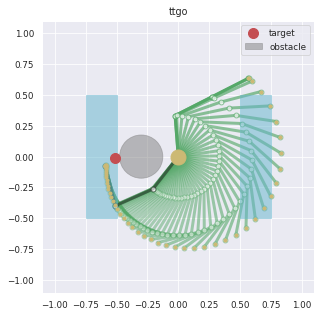

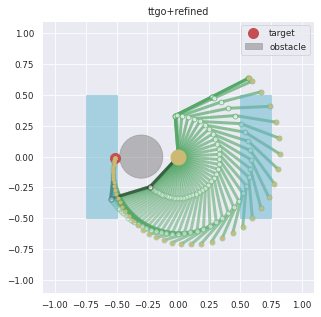

In [14]:

batch_size = x.shape[0]
x_goal_1 = x[0,:2] # desired position of ee at via point
theta_1 = x[:,2:2+n_joints] # via configuration
w = x[:,2+n_joints:] # weights of the basis function
w01 = w[:,:int(w.shape[-1])] # weights for the first part of the motion: theta_0 to theta_1 
theta_t_01 = p2p_motion.gen_traj_p2p(theta_0.view(1,-1).repeat(batch_size,1),theta_1,w01)#batchxtimexjoint_angle
T01 = theta_t_01.shape[1]
kp_loc_t_01, joint_loc_t_01, ee_loc_t_01,_ = robot.forward_kin(theta_t_01.view(-1,n_joints))



joint_loc_tt = joint_loc_t_01.view(batch_size,T01,*joint_loc_t_01.shape[1:])[0].cpu()
joint_loc_opt = joint_loc_t_01.view(batch_size,T01,*joint_loc_t_01.shape[1:])[1].cpu()

x_target = [x_goal_1.view(-1).cpu().numpy()]

x_obst_np = [x.cpu().numpy() for x in x_obst]
link_lengths_np = link_lengths.cpu().numpy()
rect_patch = [[x_min_pick,y_min_pick, x_max_pick-x_min_pick,  y_max_pick-y_min_pick],
              [x_min_place,y_min_place, x_max_place-x_min_place,  y_max_place-y_min_place]]


plt=plot_chain(joint_loc=joint_loc_tt, link_lengths=link_lengths_np, x_obst=x_obst_np,
               r_obst=r_obst, rect_patch=rect_patch, x_target=x_target, 
               batch=True, figsize=5, skip_frame=2, title=None, save_as=None, 
               color_intensity=0.9, motion=True, alpha=0.8, 
               contrast=0.4, idx_highlight=[int(joint_loc_tt.shape[0]-1)], lw=3, task=task)
plt.title('ttgo')

plt=plot_chain(joint_loc=joint_loc_opt, link_lengths=link_lengths_np, x_obst=x_obst_np,
               r_obst=r_obst, rect_patch=rect_patch, x_target=x_target, 
               batch=True, figsize=5, skip_frame=2, title=None, save_as=None, 
               color_intensity=0.9, motion=True, alpha=0.8, 
               contrast=0.4, idx_highlight=[int(joint_loc_tt.shape[0]-1)], lw=3, task=task)
plt.title('ttgo+refined')
# plt.savefig("reach-2d-tt-opt-7.png",dpi=300, pad_inches=0.01)
